In [ ]:
pip install -e ../../../dea-notebooks/Tools/

In [31]:
cd /gdata1/projects/coastal/intertidal/intertidal_change/

/gdata1/projects/coastal/intertidal/intertidal_change


In [2]:
%load_ext autoreload
%autoreload 2

import os
import tqdm
import glob
import datacube
import odc.geo.xr
import xarray as xr
import geopandas as gpd
import pandas as pd
from dea_tools.dask import create_local_dask_cluster
from dea_tools.temporal import xr_regression

dc = datacube.Datacube()
client = create_local_dask_cluster(return_client=True)

aus = gpd.read_file("/gdata1/data/boundaries/GEODATA_COAST_100K/australia/cstauscd_l.shp").query("FEAT_CODE == 'coastline'")


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46005,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:39555,Total threads: 31
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/42471/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:36685,


2024-05-15 03:48:27,442 - distributed.nanny - WARNING - Restarting worker


## Generate regression outputs

In [14]:
grid_gdf = gpd.read_file("/home/jovyan/Robbi/dea-intertidal/data/raw/ga_summary_grid_c3_32km_coastal.geojson").set_index("region_code")
region_list = grid_gdf.index

In [ ]:
outputs = []

for region_code in tqdm.tqdm(region_list):
    
    if not os.path.exists(f"{region_code}.nc"):

        query_params = dict(
            region_code=region_code,
        )

        load_params = dict(
            measurements=["elevation", "elevation_uncertainty"],
            dask_chunks={},
        )

        dss = dc.find_datasets(
            product="ga_s2ls_intertidal_cyear_3",
            **query_params,
        )

        if len(dss) > 0:

            ds = dc.load(
                product="ga_s2ls_intertidal_cyear_3",
                datasets=dss,
                **load_params,
            )

            # Mask by certainty
            ds = ds.where(ds.elevation_uncertainty < 0.3)
            ds.load()

            # Calculate regression between elevation values (3D) and time (1D)
            regression_ds = xr_regression(y=ds.elevation, x=ds.time.dt.year)
            
            # Add mean elevation to data
            regression_ds["elevation_mean"] = ds.elevation.mean(dim="time")

            # Export
            regression_ds.to_netcdf(f"{region_code}.nc")
            # for var in regression_ds.data_vars:
            #     regression_ds[var].odc.write_cog(f"{region_code}_{var}.tif", overwrite=True)

In [24]:
for region_code in tqdm.tqdm(region_list):
    
    if os.path.exists(f"{region_code}.nc"):

        query_params = dict(
            region_code=region_code,
        )

        load_params = dict(
            measurements=["elevation", "elevation_uncertainty"],
            dask_chunks={},
        )

        dss = dc.find_datasets(
            product="ga_s2ls_intertidal_cyear_3",
            **query_params,
        )

        if len(dss) > 0:

            ds = dc.load(
                product="ga_s2ls_intertidal_cyear_3",
                datasets=dss,
                **load_params,
            )

            # Mask by certainty
            ds = ds.where(ds.elevation_uncertainty < 0.3)
            ds.load()
            
            # Load regression data
            regression_ds = xr.open_dataset(
                f"{region_code}.nc",
            )

            # Add mean elevation to dataset
            regression_ds["elevation_mean"] = ds.elevation.mean(dim="time")
            regression_ds.to_netcdf(f"../intertidal_change2/{region_code}.nc")

100%|██████████| 1330/1330 [2:10:16<00:00,  5.88s/it] 


### Convert NetCDF to COG

In [ ]:
band = "pvalue"

for region_code in tqdm.tqdm(region_list): 
    
    if not os.path.exists(f"{region_code}_{band}.tif"):
    
        try:
            regression_ds = xr.open_dataset(
                f"{region_code}.nc", 
                drop_variables=["cor", "cov", "r2", "intercept", "stderr", "n"]
            )
            regression_ds[band].odc.write_cog(f"{region_code}_{band}.tif", overwrite=True)
        except:
            pass

In [9]:
# import rioxarray

# slope = rioxarray.open_rasterio("regression_slope.tif", chunks={"x": 8192, "y": 8192})
# pvalue = rioxarray.open_rasterio("regression_pvalue.tif", chunks={"x": 8192, "y": 8192})
# slope_masked = slope.where(pvalue < 0.05)

### Merge into continental layers

In [ ]:
# Set file path names
file_list_name = f"regression_{band}.txt"
vrt_name = f"regression_{band}.vrt"
output_name = f"regression_{band}.tif"
nodata = "nan"

if not os.path.exists(vrt_name):
    
    pd.Series(glob.glob(f"*_{band}.tif")).to_csv(file_list_name, index=False, header=False)

    # Use text file of file paths to create VRT
    os.system(
        f"gdalbuildvrt {vrt_name} -input_file_list {file_list_name} -vrtnodata {nodata}"
    )

# Convert VRT to COG GeoTIFF with compression
os.system(
    f"gdal_translate {vrt_name} {output_name} -co NUM_THREADS=ALL_CPUS -of COG -co BIGTIFF=YES -co COMPRESS=DEFLATE -co LEVEL=9 -co PREDICTOR=YES -co BLOCKSIZE=1024"
)

In [ ]:
!gdalinfo regression_slope.tif

## Load data and calculate stats

In [58]:
outputs_change = []
outputs_perc = []

for region_code in tqdm.tqdm(region_list):    
    
    try:
        regression_ds = xr.open_dataset(
            f"{region_code}.nc", 
            drop_variables=["cor", "cov", "r2", "intercept", "stderr", "n"]
        )

        test_data = (
            regression_ds[["slope"]]
            .where(regression_ds.pvalue < 0.05, 0)
            .where(regression_ds.slope.notnull)
        )

        test_data["lower"] = test_data.slope.where(regression_ds.elevation_mean < 0)
        test_data["upper"] = test_data.slope.where(regression_ds.elevation_mean > 0)
        test_data = test_data.rename({"slope": "all"})

        a = ((test_data < -0.1)).sum().assign_coords(category="< -0.1 m")
        b = ((test_data >= -0.1) & (test_data < -0.05)).sum().assign_coords(category="-0.05 to -0.10 m")
        c = ((test_data >= -0.05) & (test_data < -0.03)).sum().assign_coords(category="-0.03 to -0.05 m")
        d = ((test_data >= -0.03) & (test_data <= 0.03)).sum().assign_coords(category="Non-significant")
        e = ((test_data > 0.03) & (test_data <= 0.05)).sum().assign_coords(category="0.03 to 0.05 m")
        f = ((test_data > 0.05) & (test_data <= 0.10)).sum().assign_coords(category="0.05 to 0.10 m")
        g = ((test_data > 0.1)).sum().assign_coords(category="> 0.1 m")

        change_df = (xr.concat([a, b, c, d, e, f, g], dim="category")
                     .to_dataframe()
                     .drop("spatial_ref", axis=1))
        change_perc_df = (change_df * 100 / change_df.sum())
        outputs_change.append(change_df.T.assign(region=region_code))
        outputs_perc.append(change_perc_df.T.assign(region=region_code))
    except:
        pass
    
    

100%|██████████| 1330/1330 [27:51<00:00,  1.26s/it]


In [ ]:
# regression_ds = xr.open_dataset(
#             "x106y154.nc", 
#             drop_variables=["cor", "cov", "r2", "intercept", "stderr", "n"]
# )

In [ ]:
# regression_ds.slope.odc.explore(vmin=-0.05, vmax=0.05, cmap="RdBu")

In [77]:
combined_results_n = pd.merge(
    grid_gdf,
    pd.concat(outputs_change).loc["lower"].rename_axis("region_code"),
    left_index=True,
    right_index=True,
)

combined_results_perc = pd.merge(
    grid_gdf,
    pd.concat(outputs_perc).loc["lower"].set_index("region"),
    left_index=True,
    right_index=True,
)

combined_results_perc["all_loss"] = combined_results_perc.loc[:, ["< -0.1 m", "-0.05 to -0.10 m", "-0.03 to -0.05 m"]].sum(axis=1)
combined_results_perc["all_gain"] = combined_results_perc.loc[:, ["> 0.1 m", "0.05 to 0.10 m", "0.03 to 0.05 m"]].sum(axis=1)
combined_results_perc["dynamic"] = 100 - combined_results_perc["Non-significant"]
combined_results_perc["n"] = combined_results_n.iloc[:, 4:].sum(axis=1)
combined_results_perc
# combined_results_perc = combined_results_perc.query("n > 5000")

,ix,iy,type,geometry,< -0.1 m,-0.05 to -0.10 m,-0.03 to -0.05 m,Non-significant,0.03 to 0.05 m,0.05 to 0.10 m,> 0.1 m,all_loss,all_gain,dynamic,n
x079y129,79,129,mainland,"POLYGON ((113.14597 -24.19528, 113.09903 -24.4...",0.000000,0.100997,4.696377,95.164752,0.025249,0.012625,0.000000,4.797374,0.037874,4.835248,NaN
x079y130,79,130,mainland,"POLYGON ((113.19267 -23.91254, 113.14597 -24.1...",0.000000,0.151548,2.792812,96.817493,0.151548,0.086599,0.000000,2.944360,0.238147,3.182507,NaN
x079y131,79,131,mainland,"POLYGON ((113.23914 -23.62970, 113.19267 -23.9...",0.000000,0.000000,0.188385,99.746655,0.064960,0.000000,0.000000,0.188385,0.064960,0.253345,NaN
x079y135,79,135,mainland,"POLYGON ((113.42278 -22.49714, 113.37721 -22.7...",0.000000,0.093049,1.368363,98.461959,0.060208,0.010947,0.005473,1.461412,0.076628,1.538041,NaN
x079y136,79,136,mainland,"POLYGON ((113.46814 -22.21367, 113.42278 -22.4...",0.005570,0.194964,0.462344,99.309269,0.016711,0.011141,0.000000,0.662879,0.027852,0.690731,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x204y136,204,136,offshore,"POLYGON ((152.69428 -21.90686, 152.74475 -22.1...",0.000000,0.000000,0.008390,99.945465,0.037755,0.008390,0.000000,0.008390,0.046145,0.054535,NaN
x204y139,204,139,offshore,"POLYGON ((152.54432 -21.05735, 152.59407 -21.3...",0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
x204y140,204,140,offshore,"POLYGON ((152.49481 -20.77385, 152.54432 -21.0...",0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
x204y146,204,146,offshore,"POLYGON ((152.20267 -19.06895, 152.25078 -19.3...",0.154083,0.873138,0.667694,98.099640,0.154083,0.051361,0.000000,1.694915,0.205444,1.900360,NaN


In [65]:
pd.merge(
    grid_gdf,
    pd.concat(outputs_perc).loc["lower"].rename_axis("region_code"),
    left_index=True,
    right_index=True,
)

,ix,iy,type,geometry,< -0.1 m,-0.05 to -0.10 m,-0.03 to -0.05 m,Non-significant,0.03 to 0.05 m,0.05 to 0.10 m,> 0.1 m,region
region_code,,,,,,,,,,,,


category,< -0.1 m,-0.05 to -0.10 m,-0.03 to -0.05 m,Non-significant,0.03 to 0.05 m,0.05 to 0.10 m,> 0.1 m
region,,,,,,,
x079y129,0.000000,0.100997,4.696377,95.164752,0.025249,0.012625,0.000000
x079y130,0.000000,0.151548,2.792812,96.817493,0.151548,0.086599,0.000000
x079y131,0.000000,0.000000,0.188385,99.746655,0.064960,0.000000,0.000000
x079y135,0.000000,0.093049,1.368363,98.461959,0.060208,0.010947,0.005473
x079y136,0.005570,0.194964,0.462344,99.309269,0.016711,0.011141,0.000000
...,...,...,...,...,...,...,...
x204y136,0.000000,0.000000,0.008390,99.945465,0.037755,0.008390,0.000000
x204y139,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000
x204y140,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000


In [76]:
((combined_results_perc.iloc[:, 4:].sum(axis=0) * 100) / combined_results_perc.iloc[:, 4:].sum().sum()).round(2)  # upper

< -0.1 m             0.260012
-0.05 to -0.10 m     1.402972
-0.03 to -0.05 m     3.111725
Non-significant     80.863215
0.03 to 0.05 m       0.811279
0.05 to 0.10 m       0.587571
> 0.1 m              0.205368
all_loss              4.77471
all_gain             1.604219
dynamic              6.378928
n                         0.0
dtype: object

In [78]:
((combined_results_perc.iloc[:, 4:].sum(axis=0) * 100) / combined_results_perc.iloc[:, 4:].sum().sum()).round(2)  # lower

< -0.1 m             0.113596
-0.05 to -0.10 m     1.025878
-0.03 to -0.05 m      2.58405
Non-significant     86.175257
0.03 to 0.05 m       0.516838
0.05 to 0.10 m       0.306246
> 0.1 m               0.06164
all_loss             3.723524
all_gain             0.884724
dynamic              4.608248
n                         0.0
dtype: object

Text(0.5, 1.0, 'Percent with gain trend')

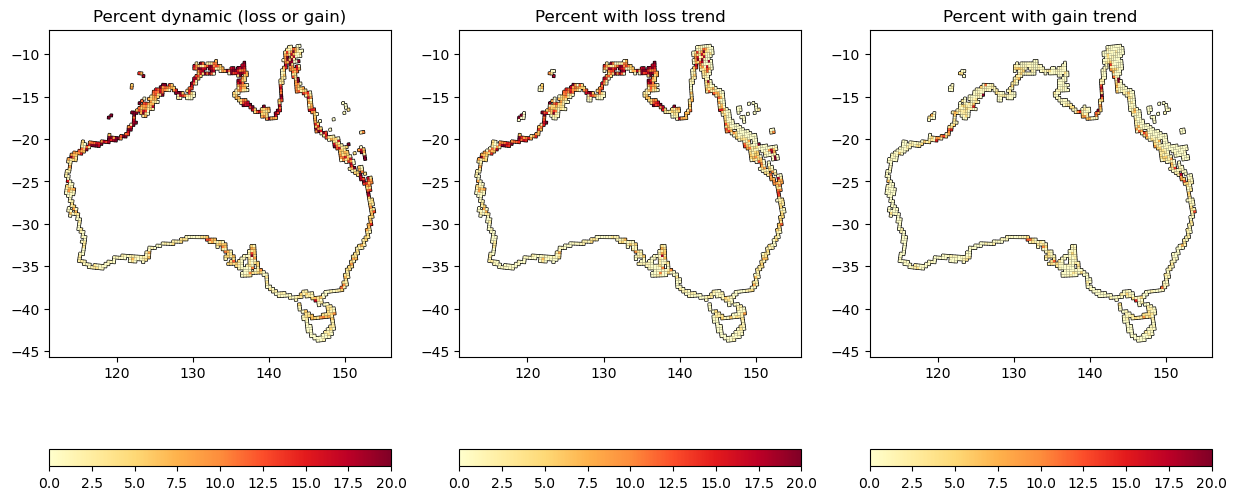

In [72]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
combined_results_perc.query("dynamic >= 0").plot(edgecolor="black", linewidth=1, ax=ax[0], zorder=0)
combined_results_perc.query("all_loss >= 0").plot(edgecolor="black", linewidth=1, ax=ax[1], zorder=0)
combined_results_perc.query("all_gain >= 0").plot(edgecolor="black", linewidth=1, ax=ax[2], zorder=0)
combined_results_perc.plot(column="dynamic", vmin=0, vmax=20, legend=True, ax=ax[0], legend_kwds={'location': 'bottom'}, cmap="YlOrRd")
combined_results_perc.plot(column="all_loss", vmin=0, vmax=20, ax=ax[1], legend=True, legend_kwds={'location': 'bottom'}, cmap="YlOrRd")
combined_results_perc.plot(column="all_gain", vmin=0, vmax=20, ax=ax[2], legend=True, legend_kwds={'location': 'bottom'}, cmap="YlOrRd")
ax[0].set_title("Percent dynamic (loss or gain)")
ax[1].set_title("Percent with loss trend")
ax[2].set_title("Percent with gain trend")

Text(0.5, 1.0, 'Percent with gain trend')

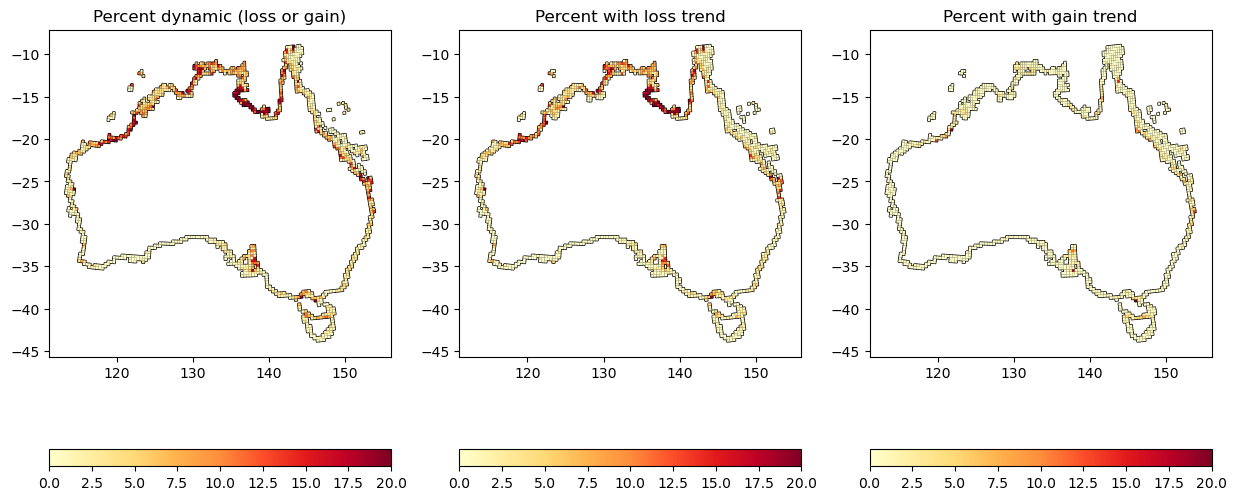

In [70]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
combined_results_perc.query("dynamic >= 0").plot(edgecolor="black", linewidth=1, ax=ax[0], zorder=0)
combined_results_perc.query("all_loss >= 0").plot(edgecolor="black", linewidth=1, ax=ax[1], zorder=0)
combined_results_perc.query("all_gain >= 0").plot(edgecolor="black", linewidth=1, ax=ax[2], zorder=0)
combined_results_perc.plot(column="dynamic", vmin=0, vmax=20, legend=True, ax=ax[0], legend_kwds={'location': 'bottom'}, cmap="YlOrRd")
combined_results_perc.plot(column="all_loss", vmin=0, vmax=20, ax=ax[1], legend=True, legend_kwds={'location': 'bottom'}, cmap="YlOrRd")
combined_results_perc.plot(column="all_gain", vmin=0, vmax=20, ax=ax[2], legend=True, legend_kwds={'location': 'bottom'}, cmap="YlOrRd")
ax[0].set_title("Percent dynamic (loss or gain)")
ax[1].set_title("Percent with loss trend")
ax[2].set_title("Percent with gain trend")

In [ ]:
combined_results

In [ ]:
combined_results = pd.merge(
    grid_gdf,
    pd.concat(outputs_change).rename_axis("region_code"),
    left_index=True,
    right_index=True,
)
combined_results["all_loss"] = combined_results.loc[:, ["< -0.1 m", "-0.05 to -0.10 m", "-0.03 to -0.05 m"]].sum(axis=1)
combined_results["all_gain"] = combined_results.loc[:, ["> 0.1 m", "0.05 to 0.10 m", "0.03 to 0.05 m"]].sum(axis=1)
combined_results["dynamic"] = 100 - combined_results["Non-significant"]

In [ ]:
combined_results.plot(column="Non-significant", vmax=500000)

## Coastal compartments

In [ ]:
compartments_gdf = gpd.read_file("/gdata1/data/beach_slopes/primary_compartments.geojson").set_index("primary_comp_id")

In [ ]:
from odc.geo.geom import Geometry

region_list = compartments_gdf.index
region_code = "NSW02.02"


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import tqdm

outputs = []

region_list = ["SA02.02"]

for region_code in tqdm.tqdm(region_list):

    geom = Geometry(compartments_gdf.loc[region_code].geometry, crs="EPSG:4326")

    query_params = dict(
        geopolygon=geom,
    )

    load_params = dict(
        measurements=["elevation", "elevation_uncertainty"],
        dask_chunks={"x": 4096, "y": 4096},
    )

    dss = dc.find_datasets(
        product="ga_s2ls_intertidal_cyear_3",
        **query_params,
    )

    if len(dss) > 0:

        ds = dc.load(
            product="ga_s2ls_intertidal_cyear_3",
            datasets=dss,
            **load_params,
        )

        # Mask by polygon extent
        ds = ds.odc.mask(geom)

        # Mask by certainty
        ds = ds.where(ds.elevation_uncertainty < 0.3)
        ds.load()

        # Stack
        ds_stacked = ds.stack(z=["y", "x"]).dropna(dim="z", how="all")

        # Calculate regression between elevation values (3D) and time (1D)
        regression_ds = xr_regression(y=ds_stacked.elevation, x=ds_stacked.time.dt.year)

        # Identify significant changes only
        sig_change = regression_ds.slope.where(regression_ds.pvalue < 0.05)

        # Mean elevation
        mean_elevation = ds_stacked.elevation.mean(dim="time")

        # Compute summary stats
        summary_df_all = (
            sig_change.to_dataframe()
            .reset_index(drop=True)
            .drop(["spatial_ref", "x", "y"], axis=1)
            .describe()
            .T.rename(index={"slope": region_code})
            .assign(classification="all")
        )

        # Compute summary stats
        summary_df_upper = (
            sig_change.where(mean_elevation > 0)
            .to_dataframe()
            .reset_index(drop=True)
            .drop(["spatial_ref", "x", "y"], axis=1)
            .describe()
            .T.rename(index={"slope": region_code})
            .assign(classification="upper")
        )

        # Compute summary stats
        summary_df_lower = (
            sig_change.where(mean_elevation < 0)
            .to_dataframe()
            .reset_index(drop=True)
            .drop(["spatial_ref", "x", "y"], axis=1)
            .describe()
            .T.rename(index={"slope": region_code})
            .assign(classification="lower")
        )

        outputs.append(summary_df_all)
        outputs.append(summary_df_upper)
        outputs.append(summary_df_lower)


In [ ]:
test_data = (
    regression_ds[["slope"]]
    .where(regression_ds.pvalue < 0.05, 0)
)

test_data["lower"] = test_data.slope.where(mean_elevation < 0)
test_data["upper"] = test_data.slope.where(mean_elevation > 0)
test_data = test_data.rename({"slope": "all"})

a = ((test_data < -0.1)).sum().assign_coords(category="< -0.1 m")
b = ((test_data >= -0.1) & (test_data < -0.05)).sum().assign_coords(category="-0.05 to -0.10 m")
c = ((test_data >= -0.05) & (test_data < -0.03)).sum().assign_coords(category="-0.03 to -0.05 m")
d = ((test_data >= -0.03) & (test_data <= 0.03)).sum().assign_coords(category="Non-significant")
e = ((test_data > 0.03) & (test_data <= 0.05)).sum().assign_coords(category="0.03 to 0.05 m")
f = ((test_data > 0.05) & (test_data <= 0.10)).sum().assign_coords(category="0.05 to 0.10 m")
g = ((test_data > 0.1)).sum().assign_coords(category="> 0.1 m")

In [ ]:
change_df = xr.concat([a, b, c, d, e, f, g], dim="category").to_dataframe().drop("spatial_ref", axis=1)
change_perc_df = (change_df * 100 / change_df.sum())

In [ ]:
change_df.round(2)

In [ ]:
change_perc_df.round(2)

In [ ]:
test = regression_ds.slope.where(mean_elevation < 0)
test.plot.hist(bins=200, xlim=(-0.25, 0.25))
plt.gca().axvline(test.median(), color="red");

In [ ]:
test = regression_ds.slope.where(mean_elevation > 0)
test.plot.hist(bins=200, xlim=(-0.25, 0.25))
plt.gca().axvline(test.median(), color="red");

In [ ]:
combined_results = pd.merge(
    compartments_gdf,
    pd.concat(outputs).rename_axis("region_code"),
    left_index=True,
    right_index=True,
)
# combined_results["geometry"] = combined_results["geometry"].centroid
combined_results["total"] = combined_results["mean"] * 7

In [ ]:
# ax = aus.plot(zorder=0, color="black", lw=0.5)

combined_results.query("(classification == 'lower')").sort_values(by="50%", key=abs).plot(
    column="50%",
    cmap="RdBu",
    vmin=-0.05,
    vmax=0.05,
    # vmin=-0.5,
    # vmax=0.5,
    # ax=ax,
    zorder=1,
    figsize=(10, 6),
    # s=15,
    linewidth=0.2,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": "Rate of change (m / year)"},
)

In [ ]:
# pd.concat(outputs).rename_axis("region_code").to_csv("intertidal_summary_stats_secondary.csv")

In [ ]:
# # combined_results[["50%", "geometry", "classification"]].pivot(columns=["classification"], values=["50%"], index="geometry").reset_index()



# pd.merge(
#     compartments_gdf,
#     pd.concat(outputs).rename_axis("region_code").pivot(columns=["classification"], values=["50%"]),
#     left_index=True,
#     right_index=True)

In [ ]:
test = pd.merge(
    compartments_gdf,
    pd.concat(outputs).rename_axis("region_code").pivot(columns=["classification"], values=["50%"]).droplevel(level=0, axis=1),
    left_index=True,
    right_index=True)

In [ ]:
test["test"] = test.upper - test.lower

In [ ]:
test.plot(column="upper", legend=True, cmap="RdBu", vmin=-0.05, vmax=0.05)

In [ ]:
test.plot(column="lower", legend=True, cmap="RdBu", vmin=-0.05, vmax=0.05)

In [ ]:
compartments_gdf.index.nlevels

In [ ]:
test.index.nlevels

## Specific tiles

In [ ]:
grid_gdf = gpd.read_file("../../data/raw/ga_summary_grid_c3_32km_coastal.geojson").set_index("region_code")

In [ ]:
region_list = grid_gdf.index

In [ ]:
# region_list = ['x149y166', 'x149y167', 'x150y165', 'x150y166', 'x150y167', 'x151y164', 'x151y165', 'x151y167', 'x152y163', 'x152y164', 'x153y162', 'x153y163', 'x153y164', 'x154y162', 'x154y163', 'x154y164', 'x155y162', 'x155y163', 'x156y161', 'x156y162', 'x157y160', 'x157y161', 'x158y159', 'x158y160', 'x159y159', 'x160y159', 'x161y157', 'x161y158', 'x161y159', 'x161y160', 'x162y157', 'x162y158', 'x162y159', 'x162y160', 'x162y161', 'x163y156', 'x163y157', 'x163y158', 'x163y159', 'x163y160', 'x164y156', 'x164y159', 'x164y160', 'x165y156', 'x166y156', 'x167y156', 'x167y157', 'x167y158', 'x168y158', 'x168y159', 'x169y159', 'x169y160', 'x169y161', 'x169y162', 'x169y163']

In [ ]:
import tqdm

outputs = []

for region_code in tqdm.tqdm(region_list):

    query_params = dict(
        region_code=region_code,
    )

    load_params = dict(
        measurements=["elevation", "elevation_uncertainty"],
        dask_chunks={"x": 1600, "y": 1600},
        # dask_chunks={},
    )

    dss = dc.find_datasets(
        product="ga_s2ls_intertidal_cyear_3",
        **query_params,
    )

    if len(dss) > 0:

        ds = dc.load(
            product="ga_s2ls_intertidal_cyear_3",
            datasets=dss,
            **load_params,
        )

        # Mask by certainty
        ds = ds.where(ds.elevation_uncertainty < 0.3)
        ds.load()

        # Calculate regression between elevation values (3D) and time (1D)
        regression_ds = xr_regression(y=ds.elevation, x=ds.time.dt.year)
        # regression_ds.load()

        # Identify significant changes only
        sig_change = regression_ds.slope.where(regression_ds.pvalue < 0.05)

        # Compute summary stats
        summary_df_all = (
            sig_change.drop_vars("spatial_ref")
            .to_dataframe()
            .dropna()
            .describe()
            .T.rename(index={"slope": region_code})
            .assign(classification="all")
        )
        
        # Compute summary stats
        summary_df_upper = (
            sig_change.where(ds.elevation > 0).drop_vars("spatial_ref")
            .to_dataframe()
            .dropna()
            .describe()
            .T.rename(index={"slope": region_code})
            .assign(classification="upper")
        )
        
        # Compute summary stats
        summary_df_lower = (
            sig_change.where(ds.elevation < 0).drop_vars("spatial_ref")
            .to_dataframe()
            .dropna()
            .describe()
            .T.rename(index={"slope": region_code})
            .assign(classification="lower")
        )

        outputs.append(summary_df_all)
        outputs.append(summary_df_upper)
        outputs.append(summary_df_lower)

In [ ]:
aus = gpd.read_file("/gdata1/data/boundaries/GEODATA_COAST_100K/australia/cstauscd_l.shp")

combined_results = pd.merge(
    grid_gdf,
    pd.concat(outputs).rename_axis("region_code"),
    left_index=True,
    right_index=True,
)
combined_results["geometry"] = combined_results["geometry"].centroid
combined_results["total"] = combined_results["mean"] * 7

In [ ]:
pd.concat(outputs).rename_axis("region_code").to_csv("intertidal_summary_stats.csv")

In [ ]:
ax = aus.query("FEAT_CODE == 'coastline'").plot(zorder=0, color="black", lw=0.5)

combined_results.query("(classification == 'upper') & (count > 5000)").sort_values(by="mean", key=abs).plot(
    column="mean",
    cmap="RdBu",
    vmin=-0.1,
    vmax=0.1,
    # vmin=-0.5,
    # vmax=0.5,
    ax=ax,
    zorder=1,
    s=15,
    legend=True,
    legend_kwds={"label": "Rate of change (m / year)"},
)

In [ ]:
ax = aus.query("FEAT_CODE == 'coastline'").plot(zorder=0, color="black", lw=0.5)

combined_results.query("(classification == 'lower') & (count > 5000)").sort_values(by="mean", key=abs).plot(
    column="mean",
    cmap="RdBu",
    vmin=-0.1,
    vmax=0.1,
    # vmin=-0.5,
    # vmax=0.5,
    ax=ax,
    zorder=1,
    s=15,
    legend=True,
    legend_kwds={"label": "Rate of change (m / year)"},
)

In [ ]:
ax = aus.query("FEAT_CODE == 'coastline'").plot(zorder=0, color="black", lw=0.5, alpha=0, figsize=(10, 10))
combined_subset = combined_results.query("(classification == 'upper') & (count > 1000)").sort_values(by="50%", key=abs)
combined_subset.plot(
    column="50%",
    cmap="RdBu",
    vmin=-0.1,
    vmax=0.1,
    # vmin=-0.3,
    # vmax=0.3,
    # edgecolor="black",
    # linewidth=0.1,
    ax=ax,
    zorder=2,
    # s=15,
    legend=True,
    legend_kwds={"label": "Rate of change (m / year)"},
    markersize=(combined_subset['count'] ** 0.5) / 25 + 5
)
combined_subset.plot(
    c="black",
    markersize=(combined_subset['count'] ** 0.5) / 25 + 10,
    ax=ax,
    zorder=1
)

In [ ]:
(combined_subset['count'] ** 0.5) / 100

In [ ]:
import matplotlib.pyplot as plt
from dea_tools.temporal import xr_regression

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for i, var in enumerate(regression_ds.data_vars):
    print(f"Plotting {var}")
    regression_ds[var].drop("spatial_ref").plot.imshow(ax=axes[i], add_labels=False, robust=True)
    axes[i].set_title(var)

In [ ]:
sig_change = regression_ds.where(regression_ds.pvalue < 0.05)

In [ ]:
sig_change.slope.drop_vars("spatial_ref").plot.hist(bins=50);

In [ ]:
regression_ds.where(regression_ds.pvalue < 0.05).slope.plot.imshow(size=10, vmin=-0.1, vmax=0.1, cmap="RdBu")

In [ ]:
regression_ds.slope.odc.write_cog("intertidal_change.tif")

In [ ]:
regression_ds.pvalue.odc.write_cog("intertidal_change_pvalue.tif")

In [ ]:
regression_ds.slope.where(regression_ds.pvalue < 0.05).odc.write_cog("intertidal_change_sig.tif")

In [ ]:

import seaborn as sns

# sns.ecdfplot(data=ds.elevation.isel(time=0).stack(z=["x", "y"]))

In [ ]:
# testing = 

data = ds.elevation.stack(z=["x", "y"]).to_dataframe().reset_index(level=["x", "y"], drop=True).dropna(subset="elevation", how='all')


# sns.ecdfplot(data=data[["elevation"]], hue="time")

In [ ]:
from dea_tools.temporal import lag_linregress_3D

In [ ]:
out = xr_regression(y=ds.elevation, x=ds.time.dt.year)

In [ ]:
# lag_linregress_3D(y=ds.elevation.isel(x=260, y=260), x=ds.time.dt.year)

In [ ]:
# from scipy import stats
# 
# stats.linregress(x=ds.time.dt.year, y=ds.elevation.isel(x=260, y=260))

In [ ]:
# test = ds[["elevation"]].polyfit(dim="time", deg=0)

In [ ]:
# test.elevation_polyfit_coefficients.plot(col="degree", robust=True)